In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

In [ ]:
from pandas._libs import index
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Annotated/220_1.csv', delimiter=';')
display(train)
train = train.drop(columns=['TVD_(m)','DEPTH_(m)','HDTH_(m)','BLKP_(m)','ROP5_(m/h)','RPM_(c/min)','STOR_(kN.m)','SWOB_(1000 kgf)','TFLO_(L/min)','SPPA_(bar)','labels'])
test = train.tail(20000)
train = train.head(45000)
#train['TIME_(s)']=[int(round(pd.to_datetime(train['TIME_(s)'][i]).timestamp())) for i in range(0,len(train['TIME_(s)']))]
train.rename(columns={'TIME_(s)' : 'Date','HKLA_(1000 kgf)' : 'Total'}, inplace=True)
#test['TIME_(s)']=[int(round(pd.to_datetime(test['TIME_(s)'][i]).timestamp())) for i in range(105934,125934)]
test.rename(columns={'TIME_(s)' : 'Date', 'HKLA_(1000 kgf)' : 'Total'}, inplace=True)
train.set_index('Date', inplace=True)
test.set_index('Date', inplace=True)
print(train)

,TIME_(s),TVD_(m),DEPTH_(m),HDTH_(m),BLKP_(m),HKLA_(1000 kgf),ROP5_(m/h),RPM_(c/min),STOR_(kN.m),SWOB_(1000 kgf),TFLO_(L/min),SPPA_(bar),labels
0,2015-04-28 08:00:00,NaN,NaN,3602.011,4.05358,28.64885,NaN,-0.02821,-0.093415,-2.00262,0.0,-0.016626,success
1,2015-04-28 08:00:10,NaN,NaN,3602.011,4.05358,28.63197,NaN,-0.02849,-0.093198,-1.97778,0.0,-0.016660,success
2,2015-04-28 08:00:20,NaN,NaN,3602.011,4.05358,28.62236,NaN,-0.02894,-0.093022,-1.96641,0.0,-0.016609,success
3,2015-04-28 08:00:30,NaN,NaN,3602.011,4.68674,28.49389,NaN,-0.02838,-0.092845,-1.76878,0.0,-0.016122,success
4,2015-04-28 08:00:40,NaN,NaN,3602.011,5.89757,28.14165,NaN,-0.02872,-0.092845,-1.29060,0.0,-0.016090,success
...,...,...,...,...,...,...,...,...,...,...,...,...,...
125929,2015-05-12 21:48:10,267.7914,268.52548,5565.004,4.10823,24.93167,NaN,0.14390,-0.139831,0.00000,0.0,0.152866,success
125930,2015-05-12 21:48:20,267.7914,268.52548,5565.004,4.10823,25.00348,NaN,0.14420,-0.140156,40.87914,0.0,0.153982,success
125931,2015-05-12 21:48:30,267.7914,268.52548,5565.004,4.10823,25.01339,NaN,0.14332,-0.139993,40.87940,0.0,0.153383,success
125932,2015-05-12 21:48:40,267.7914,268.52548,5565.004,4.10823,25.02542,NaN,0.14569,-0.139451,40.86797,0.0,0.153397,success


                        Total
Date                         
2015-04-28 08:00:00  28.64885
2015-04-28 08:00:10  28.63197
2015-04-28 08:00:20  28.62236
2015-04-28 08:00:30  28.49389
2015-04-28 08:00:40  28.14165
...                       ...
2015-05-03 12:59:10  24.82449
2015-05-03 12:59:20  24.82211
2015-05-03 12:59:30  24.83569
2015-05-03 12:59:40  24.82616
2015-05-03 12:59:50  24.83115

[45000 rows x 1 columns]


## Isolation forest

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

In [ ]:
train = train.fillna(0)
test = test.fillna(0)

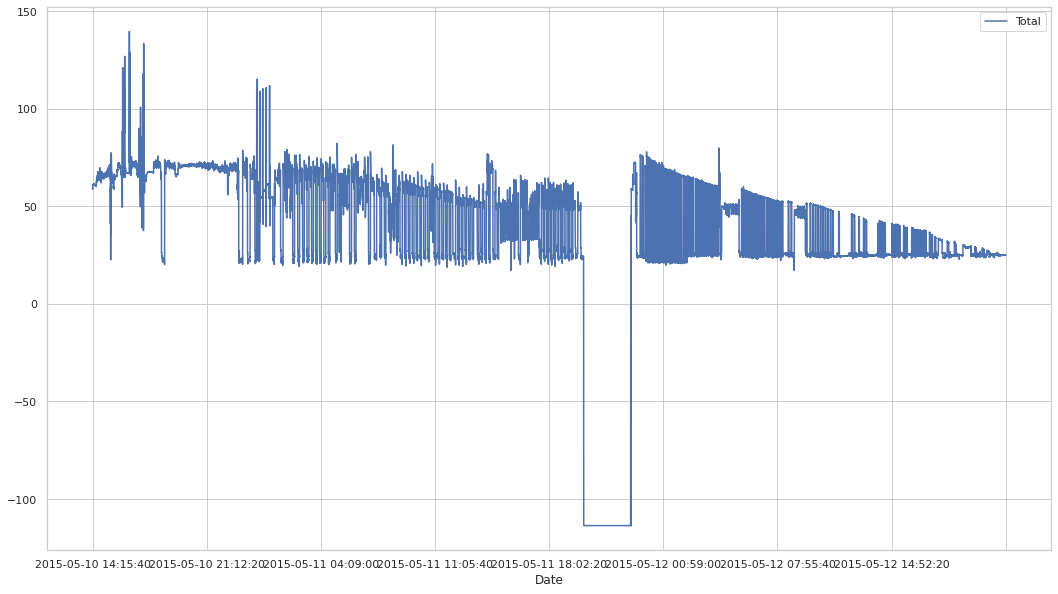

In [ ]:
plt.rc('figure',figsize=(18,10))
plt.rc('font',size=15)
test.plot()

In [ ]:
outliers_fraction = float(.01)

In [ ]:
scaler = StandardScaler()
np_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
data = pd.DataFrame(np_scaled)
np_scaled = scaler.fit_transform(test.values.reshape(-1, 1))
data_test = pd.DataFrame(np_scaled)


In [ ]:
data

,0
0,-1.089967
1,-1.091047
2,-1.091662
3,-1.099884
4,-1.122427
...,...
44995,-1.334718
44996,-1.334870
44997,-1.334001
44998,-1.334611


In [ ]:
# train isolation forest
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data) 

IsolationForest(contamination=0.01)

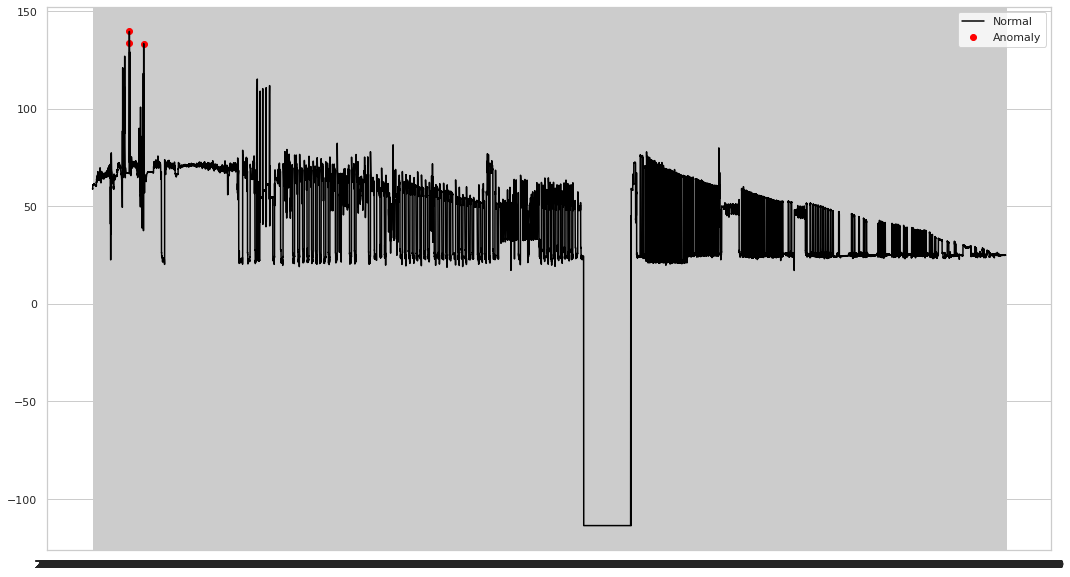

In [ ]:
test['anomaly'] = model.predict(data_test)

# visualization
fig, ax = plt.subplots(figsize=(18,10))

a = test.loc[test['anomaly'] == -1, ['Total']] #anomaly

ax.plot(test.index, test['Total'], color='black', label = 'Normal')
ax.scatter(a.index,a['Total'], color='red', label = 'Anomaly')
plt.legend()
plt.show();

In [ ]:
a.to_excel("/content/drive/MyDrive/Colab Notebooks/datasets/нир.xlsx")

## Kmeans

# Random forest

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
RSEED = 50

In [ ]:
from pandas.core.frame import DataFrame
#без 220_1
temp_arr = np.array([
                      '/content/drive/MyDrive/Colab Notebooks/Annotated/276_SMNG_276_Механический_Каротаж_200403-200411_Режим_записи.csv',
                     
                     '/content/drive/MyDrive/Colab Notebooks/Annotated/243_1.csv',
                      '/content/drive/MyDrive/Colab Notebooks/Annotated/243_2.csv',
'/content/drive/MyDrive/Colab Notebooks/Annotated/243_3.csv',
'/content/drive/MyDrive/Colab Notebooks/Annotated/243_4.csv',
'/content/drive/MyDrive/Colab Notebooks/Annotated/243_5.csv',
                     
                     '/content/drive/MyDrive/Colab Notebooks/Annotated/248_1.csv',
                     '/content/drive/MyDrive/Colab Notebooks/Annotated/248_2.csv',
                     '/content/drive/MyDrive/Colab Notebooks/Annotated/248_3.csv',
                     '/content/drive/MyDrive/Colab Notebooks/Annotated/248_4.csv',
                     '/content/drive/MyDrive/Colab Notebooks/Annotated/248_5.csv'
                     ])
df = pd.DataFrame()
for i in range(0,len(temp_arr)):
  temp = pd.read_csv(temp_arr[i],delimiter=';')
  df = pd.concat([df,temp],ignore_index=True)

In [ ]:
display(df)

,TIME_(s),TVD_(m),DEPTH_(m),HDTH_(m),BLKP_(m),HKLA_(1000 kgf),ROP5_(m/h),RPM_(c/min),STOR_(kN.m),SWOB_(1000 kgf),TFLO_(L/min),SPPA_(bar),labels
0,2015-04-28 08:00:00,NaN,NaN,3602.011,4.05358,28.64885,NaN,-0.02821,-0.093415,-2.00262,0.0,-0.016626,success
1,2015-04-28 08:00:10,NaN,NaN,3602.011,4.05358,28.63197,NaN,-0.02849,-0.093198,-1.97778,0.0,-0.016660,success
2,2015-04-28 08:00:20,NaN,NaN,3602.011,4.05358,28.62236,NaN,-0.02894,-0.093022,-1.96641,0.0,-0.016609,success
3,2015-04-28 08:00:30,NaN,NaN,3602.011,4.68674,28.49389,NaN,-0.02838,-0.092845,-1.76878,0.0,-0.016122,success
4,2015-04-28 08:00:40,NaN,NaN,3602.011,5.89757,28.14165,NaN,-0.02872,-0.092845,-1.29060,0.0,-0.016090,success
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1027691,2019-07-05 20:11:13,220.3666,220.674,8698.829,11.73870,26.45220,NaN,0.02470,-0.362866,0.00000,0.0,1.312868,success
1027692,2019-07-05 20:11:23,220.3666,220.674,8698.829,11.73870,26.40500,NaN,0.02480,-0.362052,0.00000,0.0,1.314286,success
1027693,2019-07-05 20:11:33,220.3666,220.674,8698.829,11.73870,26.37780,NaN,0.02690,-0.362730,0.00000,0.0,1.311551,success
1027694,2019-07-05 20:11:43,220.3666,220.674,8698.829,11.73870,26.44850,NaN,0.02620,-0.363544,0.00000,0.0,1.312868,success


In [ ]:
#temp0 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Annotated/220_1.csv',delimiter=';')
temp = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Annotated/241_1.csv',delimiter=';')
temp1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Annotated/241_2.csv',delimiter=';')
temp2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Annotated/241_3.csv',delimiter=';')
temp3 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Annotated/241_4.csv',delimiter=';')


temp11 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Annotated/248_1.csv',delimiter=';')
temp12 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Annotated/248_2.csv',delimiter=';')
temp13 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Annotated/248_3.csv',delimiter=';')
temp14 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Annotated/248_4.csv',delimiter=';')
temp15 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Annotated/248_5.csv',delimiter=';')
df1 = pd.concat([temp,temp1,temp2,temp3],ignore_index=True)

In [ ]:
display(df1)

,TIME_(s),HDTH_(m),DEPTH_(m),ROP5_(m/h),SWOB_(1000 kgf),SPPA_(bar),TFLO_(L/min),STOR_(kN.m),RPM_(c/min),HKLA_(1000 kgf),BLKP_(m),TVD_(m),labels
0,2019-04-21 04:37:18,5604.998,46.4685,NaN,0.0,1.431793,0.0,-0.401905,-0.01634,22.76945,3.85908,46.46843,success
1,2019-04-21 04:37:28,5604.998,46.4685,NaN,0.0,1.430719,0.0,-0.402773,-0.01799,23.00671,3.58605,46.46843,success
2,2019-04-21 04:37:38,5604.998,46.4685,NaN,0.0,1.430233,0.0,-0.401742,-0.01613,23.00936,3.58605,46.46843,success
3,2019-04-21 04:37:48,5604.998,46.4685,NaN,0.0,1.430263,0.0,-0.401729,-0.01720,23.00790,3.58605,46.46843,success
4,2019-04-21 04:37:58,5604.998,46.4685,NaN,0.0,1.428682,0.0,-0.402230,-0.01907,25.34327,2.65502,46.46843,success
...,...,...,...,...,...,...,...,...,...,...,...,...,...
510508,2019-07-05 20:11:13,8698.829,220.6740,NaN,0.0,1.312868,0.0,-0.362866,0.02470,26.45220,11.73870,220.36660,success
510509,2019-07-05 20:11:23,8698.829,220.6740,NaN,0.0,1.314286,0.0,-0.362052,0.02480,26.40500,11.73870,220.36660,success
510510,2019-07-05 20:11:33,8698.829,220.6740,NaN,0.0,1.311551,0.0,-0.362730,0.02690,26.37780,11.73870,220.36660,success
510511,2019-07-05 20:11:43,8698.829,220.6740,NaN,0.0,1.312868,0.0,-0.363544,0.02620,26.44850,11.73870,220.36660,success


In [ ]:
temp4 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Annotated/257_1.csv',delimiter=';')
temp5 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Annotated/257_2.csv',delimiter=';')
temp6 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Annotated/257_3.csv',delimiter=';')
temp7 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Annotated/260_1.csv',delimiter=';')
temp8 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Annotated/260_2.csv',delimiter=';')
temp9 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Annotated/260_3.csv',delimiter=';')
temp10 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Annotated/260_4.csv',delimiter=';')

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Annotated/241_3.csv',delimiter=';')

In [ ]:
time = np.array(df1['TIME_(s)'])
print(time)

['2012-06-01 19:38:40' '2012-06-01 19:38:50' '2012-06-01 19:39:00' ...
 '2012-04-03 11:11:47' '2012-04-03 11:11:57' '2012-04-03 11:12:07']


In [ ]:
df.drop('TIME_(s)', axis=1, inplace=True)
df.drop('DEPTH_(m)',axis=1,inplace=True)
df.drop('ROP5_(m/h)',axis=1,inplace=True)
df.drop('HKLA_(1000 kgf)',axis=1,inplace=True)
#df.drop('STOR_(kN.m)',axis=1,inplace=True)
df.drop('SWOB_(1000 kgf)',axis=1,inplace=True)
df.drop('BLKP_(m)',axis=1,inplace=True)

# df.drop('TFLO_(L/min)',axis=1,inplace=True)
# df.drop('SPPA_(bar)',axis=1,inplace=True)
# df.drop('RPM_(c/min)',axis=1,inplace=True)
# df.drop('HDTH_(m)',axis=1,inplace=True)


df.loc[(df.labels == 'success' ), 'labels'] = 1
df.loc[(df.labels == 'Pack-off' ), 'labels'] = 0

df = df.replace({'Not Available': np.nan})


# Iterate through the columns
for col in list(df.columns):
    # Select columns that should be numeric
    if ( 'TVD_(m)' in col or 'DEPTH_(m)' in col or 'HDTH_(m)' in 
        col or 'BLKP_(m)' in col or 'HKLA_(1000 kgf)' in col or 'ROP5_(m/h)' in col or 'RPM_(c/min)' in col or 'STOR_(kN.m)' in col or 'SWOB_(1000 kgf)' in col or 'TFLO_(L/min)' in col or 'SPPA_(bar)' in col or 'labels' in col):
        # Convert the data type to float
        df[col] = df[col].astype(float)


In [ ]:
df1.drop('TIME_(s)', axis=1, inplace=True)
df1.drop('DEPTH_(m)',axis=1,inplace=True)
df1.drop('ROP5_(m/h)',axis=1,inplace=True)
df1.drop('HKLA_(1000 kgf)',axis=1,inplace=True)
#df1.drop('STOR_(kN.m)',axis=1,inplace=True)
df1.drop('SWOB_(1000 kgf)',axis=1,inplace=True)
df1.drop('BLKP_(m)',axis=1,inplace=True)

# df1.drop('TFLO_(L/min)',axis=1,inplace=True)
# df1.drop('SPPA_(bar)',axis=1,inplace=True)
# df1.drop('RPM_(c/min)',axis=1,inplace=True)
# df1.drop('HDTH_(m)',axis=1,inplace=True)


df1.loc[(df1.labels == 'success' ), 'labels'] = 1
df1.loc[(df1.labels == 'Pack-off' ), 'labels'] = 0

df1 = df1.replace({'Not Available': np.nan})

for col in list(df1.columns):
    # Select columns that should be numeric
    if ( 'TVD_(m)' in col or 'DEPTH_(m)' in col or 'HDTH_(m)' in 
        col or 'BLKP_(m)' in col or 'HKLA_(1000 kgf)' in col or 'ROP5_(m/h)' in col or 'RPM_(c/min)' in col or 'STOR_(kN.m)' in col or 'SWOB_(1000 kgf)' in col or 'TFLO_(L/min)' in col or 'SPPA_(bar)' in col or 'labels' in col):
        # Convert the data type to float
        df1[col] = df1[col].astype(float)

In [ ]:
# Extract the labels
train_labels = np.array(df.pop('labels'))
train = df

In [ ]:
test_labels = np.array(df1.pop('labels'))
test = df1

In [ ]:
np.unique(test_labels)
count = 0
for i in range(0,len(test_labels)):
  if(test_labels[i] == "Pack-off"):
    count+1


In [ ]:
train = train.fillna(0)
test = test.fillna(0)

# Features for feature importances
features = list(train.columns)

удаление выбросов

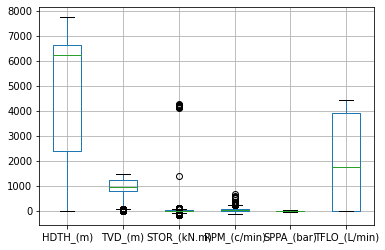

In [ ]:
test.boxplot()

In [ ]:
names = test.columns
for j in range(0,len(names)):
  for i in [names[j]]:
      q75,q25 = np.percentile(test.loc[:,i],[75,25])
      intr_qr = q75-q25

      max = q75+(1.5*intr_qr)
      min = q25-(1.5*intr_qr)

      test.loc[test[i] < min,i] = np.nan
      test.loc[test[i] > max,i] = np.nan


In [ ]:
test.isnull().sum()


HDTH_(m)            0
TVD_(m)         12704
STOR_(kN.m)      3624
RPM_(c/min)        96
SPPA_(bar)          0
TFLO_(L/min)        0
dtype: int64

In [ ]:
test = test.fillna(0)

In [ ]:
test.isnull().sum()


HDTH_(m)        0
TVD_(m)         0
STOR_(kN.m)     0
RPM_(c/min)     0
SPPA_(bar)      0
TFLO_(L/min)    0
dtype: int64

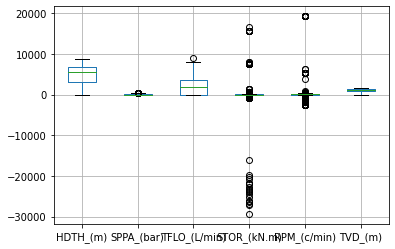

In [ ]:
train.boxplot()

In [ ]:
names = train.columns
for j in range(0,len(names)):
  for i in [names[j]]:
      q75,q25 = np.percentile(train.loc[:,i],[75,25])
      intr_qr = q75-q25

      max = q75+(1.5*intr_qr)
      min = q25-(1.5*intr_qr)

      train.loc[train[i] < min,i] = np.nan
      train.loc[train[i] > max,i] = np.nan

In [ ]:
train.isnull().sum()


HDTH_(m)           0
SPPA_(bar)        24
TFLO_(L/min)       1
STOR_(kN.m)     6739
RPM_(c/min)     3408
TVD_(m)            0
dtype: int64

In [ ]:
train = train.fillna(0)

In [ ]:
train.isnull().sum()


HDTH_(m)        0
SPPA_(bar)      0
TFLO_(L/min)    0
STOR_(kN.m)     0
RPM_(c/min)     0
TVD_(m)         0
dtype: int64

нормализация данных

In [ ]:
from sklearn import preprocessing

In [ ]:
names = test.columns

d = test.to_numpy()
d = np.transpose(d)

for i in range(0,d.shape[0]):
  d[i] = preprocessing.normalize([d[i]])

test = pd.DataFrame(d)
test = test.transpose()
test.columns = names

display(test)

,HDTH_(m),TVD_(m),STOR_(kN.m),RPM_(c/min),SPPA_(bar),TFLO_(L/min)
0,0.000000,0.0,-0.000001,-2.352359e-08,-0.000003,0.0
1,0.001961,0.0,-0.000001,-1.032297e-07,-0.000003,0.0
2,0.001961,0.0,-0.000001,-3.083189e-08,-0.000003,0.0
3,0.001961,0.0,-0.000001,-8.039129e-08,-0.000003,0.0
4,0.001961,0.0,-0.000001,-6.942884e-08,-0.000003,0.0
...,...,...,...,...,...,...
391244,0.000260,0.0,0.001156,-1.223683e-06,-0.000007,0.0
391245,0.000260,0.0,0.001156,-1.257484e-06,-0.000007,0.0
391246,0.000260,0.0,0.001155,-1.191481e-06,-0.000007,0.0
391247,0.000260,0.0,0.001155,-1.199475e-06,-0.000007,0.0


In [ ]:
names = train.columns

d = train.to_numpy()
d = np.transpose(d)

for i in range(0,d.shape[0]):
  d[i] = preprocessing.normalize([d[i]])

train = pd.DataFrame(d)
train = train.transpose()
train.columns = names

display(train)

,HDTH_(m),SPPA_(bar),TFLO_(L/min),STOR_(kN.m),RPM_(c/min),TVD_(m)
0,0.000009,0.000005,0.0,-0.001177,0.000000e+00,0.000000
1,0.000009,0.000005,0.0,-0.001177,0.000000e+00,0.000000
2,0.000009,0.000005,0.0,-0.001177,0.000000e+00,0.000000
3,0.000009,0.000005,0.0,-0.001177,0.000000e+00,0.000000
4,0.000009,0.000005,0.0,-0.001177,0.000000e+00,0.000000
...,...,...,...,...,...,...
1038485,0.001569,0.000010,0.0,-0.000013,3.055539e-07,0.000198
1038486,0.001569,0.000010,0.0,-0.000013,3.067910e-07,0.000198
1038487,0.001569,0.000010,0.0,-0.000013,3.327693e-07,0.000198
1038488,0.001569,0.000010,0.0,-0.000013,3.241098e-07,0.000198


In [ ]:
# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

# Fit on training data
model.fit(train, train_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished


RandomForestClassifier(max_features='sqrt', n_jobs=-1, random_state=50,
                       verbose=1)

In [ ]:
# Извлекаем значимость параметров
fi = pd.DataFrame({'feature': list(train.columns),
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)

# Выводим значения
display(fi)

,feature,importance
5,TVD_(m),0.313758
2,TFLO_(L/min),0.193517
1,SPPA_(bar),0.189400
4,RPM_(c/min),0.155873
3,STOR_(kN.m),0.099183
0,HDTH_(m),0.048268


In [ ]:
# Действующая классификация
rf_predictions = model.predict(test)
# Вероятности для каждого класса
rf_probs = model.predict_proba(test)[:, 1]
print(rf_predictions)
print(rf_probs)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.4s finished
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.7s


[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.5s finished


In [ ]:
np.unique(rf_predictions)

array([1.])

In [ ]:
from sklearn.metrics import roc_auc_score

# Рассчитываем roc auc
roc_value = roc_auc_score(test_labels, rf_probs)
print(roc_value)

0.5549578197461085


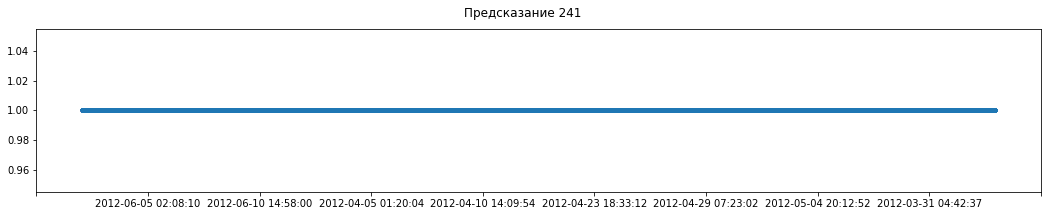

In [ ]:
from matplotlib.ticker import LinearLocator
X = time
fig, ax = plt.subplots(figsize=(18,3))
ax.xaxis.set_major_locator(LinearLocator(10))
plt.suptitle('Предсказание 241')
plt.scatter(X,rf_predictions,s=5)

plt.show()

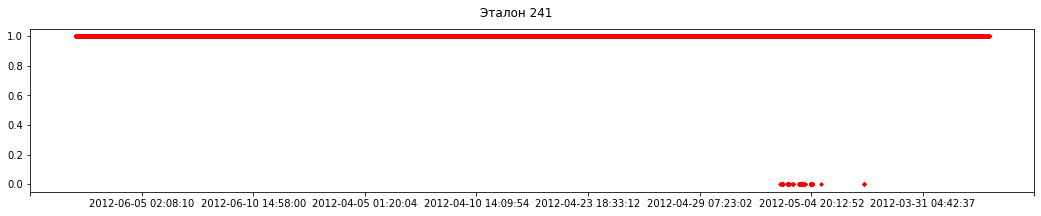

In [ ]:
from matplotlib.ticker import LinearLocator

X = time
fig, ax = plt.subplots(figsize=(18,3))
ax.xaxis.set_major_locator(LinearLocator(10))
plt.suptitle('Эталон 241')
plt.scatter(X, test_labels,color='red',s=5)

plt.show()

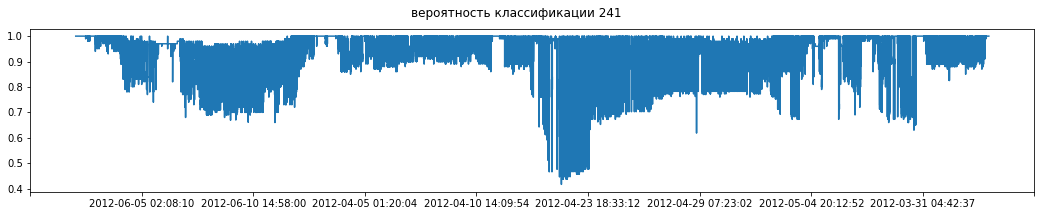

In [ ]:
from matplotlib.ticker import LinearLocator

X = time
fig, ax = plt.subplots(figsize=(18,3))
ax.xaxis.set_major_locator(LinearLocator(10))
plt.suptitle('вероятность классификации 241')

plt.plot(X, rf_probs)

plt.show()

как было: треин - 248, 276, 220; тест - 220 или 241

In [ ]:
#нормализация
from sklearn import preprocessing

d = preprocessing.normalize(test)
names = test.columns
d=d.transpose()
print(d.shape)

(6, 391249)


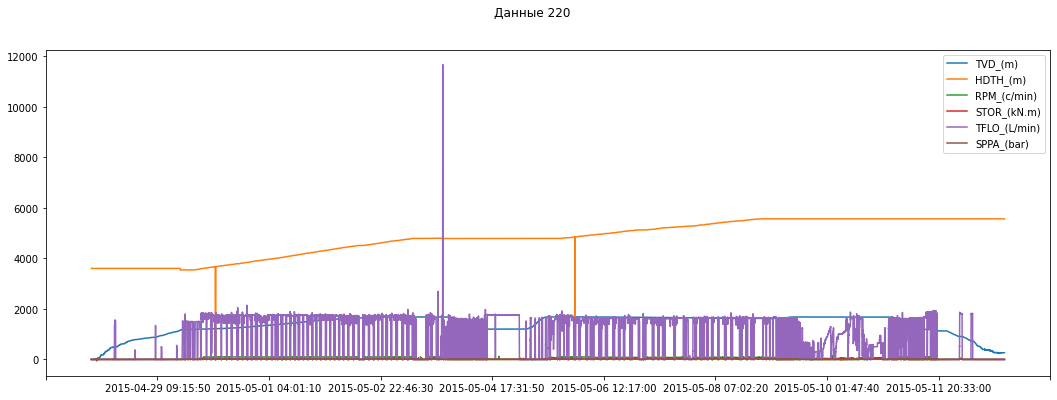

In [ ]:
from matplotlib import legend
from matplotlib.ticker import LinearLocator

X = time
fig, ax = plt.subplots(figsize=(18,6))
ax.xaxis.set_major_locator(LinearLocator(10))
plt.suptitle('Данные 220')
for i in range(0,arr_test.shape[0]):
  plt.plot(X, arr_test[i], label=names[i])
plt.legend()
plt.show()